## EDA

### 1.1: Load the Dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
from utils import FitData


In [ ]:
import os

# Create data folder if it doesn't exist
data_dir = "data"
os.makedirs(data_dir, exist_ok=True)

# Dataset URL
url = "https://files.grouplens.org/datasets/movielens/ml-32m.zip"

zip_file = os.path.join(data_dir, "ml-32m.zip")
extract_folder = os.path.join(data_dir, "ml-32m")

print(f"Starting download of {url}...")

# Download into data/ folder
!wget -q $url -O $zip_file

print("Download complete.")

# Verify download
if os.path.exists(zip_file):
    print(f"Successfully downloaded {zip_file}.")

    # Unzip into data/ml-32m/
    print(f"Unzipping {zip_file}...")
    !unzip -o $zip_file -d $extract_folder

    print(f"Successfully unzipped to '{extract_folder}' folder.")

    # List extracted contents
    print(f"\nContents of {extract_folder}:")
    !ls -l $extract_folder
else:
    print(f"Error: {zip_file} was not downloaded.")


Starting download of https://files.grouplens.org/datasets/movielens/ml-32m.zip...
Download complete.
Successfully downloaded data/ml-32m.zip.
Unzipping data/ml-32m.zip...
Archive:  data/ml-32m.zip
  inflating: data/ml-32m/ml-32m/tags.csv  
  inflating: data/ml-32m/ml-32m/links.csv  
  inflating: data/ml-32m/ml-32m/README.txt  
  inflating: data/ml-32m/ml-32m/checksums.txt  
  inflating: data/ml-32m/ml-32m/ratings.csv  
  inflating: data/ml-32m/ml-32m/movies.csv  
Successfully unzipped to 'data/ml-32m' folder.

Contents of data/ml-32m:
total 9
drwxrwxr-x 2 dolan people 8 Nov 21 15:26 ml-32m


In [ ]:
ratings_path = "data/ml-32m/ml-32m/ratings.csv"
movies_path = "data/ml-32m/ml-32m/movies.csv"

data = FitData(ratings_path, movies_path)
data.load()


### 1.3: Plottings

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from collections import Counter
import csv

# Optional: scipy.sparse for spy visualization if installed
try:
    from scipy import sparse
    SCIPY_SPARSE_AVAILABLE = True
except Exception:
    SCIPY_SPARSE_AVAILABLE = False

# ---------------------------
# Extract arrays directly from FitData
# ---------------------------
def extract_arrays_from_fitdata(fd):
    """
    Extract flat arrays of user IDs, movie IDs, and scores from a FitData instance.
    Returns:
        users_arr, movies_arr, scores_arr, timestamps_arr (None if not present)
    """
    users_list = []
    movies_list = []
    scores_list = []

    for u_idx, ratings in enumerate(fd.data_by_user):
        user_id = fd.idx_to_user_id[u_idx]
        for movie_id, rating in ratings:
            users_list.append(user_id)
            movies_list.append(movie_id)
            scores_list.append(rating)

    users_arr = np.asarray(users_list)
    movies_arr = np.asarray(movies_list)
    scores_arr = np.asarray(scores_list, dtype=float)

    # timestamps not available in current FitData
    timestamps_arr = None

    return users_arr, movies_arr, scores_arr, timestamps_arr

# ---------------------------
# Initialize FitData and extract arrays
# ---------------------------
ratings_path = "data/ml-32m/ml-32m/ratings.csv"
movies_path = "data/ml-32m/ml-32m/movies.csv"

data = FitData(ratings_path, movies_path)
data.load()

users_arr, movies_arr, scores_arr, timestamps_arr = extract_arrays_from_fitdata(data)

# ---------------------------
# Basic counts & mappings
# ---------------------------
user_ids, user_counts = np.unique(users_arr, return_counts=True)
movie_ids, movie_counts = np.unique(movies_arr, return_counts=True)
n_users = len(user_ids)
n_movies = len(movie_ids)
n_ratings = len(scores_arr)
total_possible = n_users * n_movies
sparsity_percent = 100.0 * (1 - n_ratings / float(total_possible)) if total_possible>0 else np.nan

# Map raw IDs to contiguous indices
user_to_idx = {uid: i for i, uid in enumerate(user_ids)}
movie_to_idx = {mid: i for i, mid in enumerate(movie_ids)}
user_idx = np.array([user_to_idx[u] for u in users_arr], dtype=int)
movie_idx = np.array([movie_to_idx[m] for m in movies_arr], dtype=int)

# Create counters
user_counter = Counter(user_idx)
movie_counter = Counter(movie_idx)

# Create figures folder if it doesn't exist
FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

# Utility: safe save figure as PDF and close
def save_pdf(fig, filename):
    filepath = os.path.join(FIG_DIR, filename)
    fig.savefig(filepath, format='pdf', bbox_inches='tight')
    plt.close(fig)
    print(f"✓ Saved: {filepath}")

# ---------------------------
# 1) Rating histogram + simple density (smoothed histogram)
# ---------------------------
def plot_rating_histogram(scores, filename='01_rating_histogram.pdf'):
    fig, ax = plt.subplots(figsize=(8,6))
    bins = np.arange(np.floor(scores.min()) - 0.5, np.ceil(scores.max()) + 0.5, 0.5)
    counts, edges, patches = ax.hist(scores, bins=bins, edgecolor='black', linewidth=0.6)
    ax.set_title('Rating Distribution (Histogram)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Rating')
    ax.set_ylabel('Count')
    # simple smoothing line: normalized counts via moving average on bin centers
    centers = (edges[:-1] + edges[1:]) / 2.0
    window = 3
    smooth = np.convolve(counts, np.ones(window)/window, mode='same')
    ax.plot(centers, smooth, linewidth=2.0)
    # stats box
    ax.text(0.02, 0.98, f'N={len(scores):,}\nMean={scores.mean():.3f}\nMedian={np.median(scores):.2f}\nStd={scores.std():.3f}',
            transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    plt.tight_layout()
    save_pdf(fig, filename)

# ---------------------------
# 2) Rating value counts (bar)
# ---------------------------
def plot_rating_value_counts(scores, filename='02_rating_value_counts.pdf'):
    unique_vals, counts = np.unique(scores, return_counts=True)
    fig, ax = plt.subplots(figsize=(8,6))
    ax.bar(unique_vals, counts, width=0.4, edgecolor='black')
    ax.set_xticks(unique_vals)
    ax.set_title('Count by Rating Value', fontsize=14, fontweight='bold')
    ax.set_xlabel('Rating')
    ax.set_ylabel('Count')
    # annotate values
    for x, c in zip(unique_vals, counts):
        ax.text(x, c, f'{c:,}', ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    save_pdf(fig, filename)

# ---------------------------
# 3) Rating boxplot
# ---------------------------
def plot_rating_boxplot(scores, filename='03_rating_boxplot.pdf'):
    fig, ax = plt.subplots(figsize=(6,6))
    bp = ax.boxplot(scores, vert=True, widths=0.5, patch_artist=True, notch=False)
    # style manually (no seaborn)
    for box in bp['boxes']:
        box.set(facecolor='#cfe8ff', edgecolor='navy')
    for median in bp['medians']:
        median.set(color='red', linewidth=2)
    ax.set_xticks([1])
    ax.set_xticklabels(['All Ratings'])
    ax.set_ylabel('Rating')
    ax.set_title('Rating Distribution (Box Plot)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    save_pdf(fig, filename)

# ---------------------------
# 4) User activity distribution histogram + CCDF
# ---------------------------
def plot_user_activity(user_counts_raw, filename_hist='04_user_activity_hist.pdf', filename_ccdf='05_user_activity_ccdf.pdf'):
    counts = user_counts_raw.copy()
    fig, ax = plt.subplots(figsize=(8,6))
    bins = np.logspace(0, math.ceil(math.log10(counts.max()+1)), 50)
    ax.hist(counts, bins=bins, edgecolor='black')
    ax.set_xscale('log')
    ax.set_xlabel('Number of Ratings per User (log scale)')
    ax.set_ylabel('Number of Users')
    ax.set_title('User Activity Distribution (Histogram, log x)')
    plt.tight_layout()
    save_pdf(fig, filename_hist)

    # CCDF
    sorted_counts = np.sort(counts)
    ranks = np.arange(1, len(sorted_counts)+1)
    ccdf = 1.0 - np.arange(len(sorted_counts)) / float(len(sorted_counts))
    fig, ax = plt.subplots(figsize=(8,6))
    ax.loglog(sorted_counts[::-1], ccdf, marker='.', linestyle='none')
    ax.set_xlabel('k (ratings per user)')
    ax.set_ylabel('CCDF P(X >= k)')
    ax.set_title('User Activity CCDF (log-log)')
    plt.tight_layout()
    save_pdf(fig, filename_ccdf)

# ---------------------------
# 5) Movie popularity distribution histogram + CCDF
# ---------------------------
def plot_movie_popularity(movie_counts_raw, filename_hist='06_movie_popularity_hist.pdf', filename_ccdf='07_movie_popularity_ccdf.pdf'):
    counts = movie_counts_raw.copy()
    fig, ax = plt.subplots(figsize=(8,6))
    bins = np.logspace(0, math.ceil(math.log10(counts.max()+1)), 50)
    ax.hist(counts, bins=bins, edgecolor='black')
    ax.set_xscale('log')
    ax.set_xlabel('Number of Ratings per Movie (log scale)')
    ax.set_ylabel('Number of Movies')
    ax.set_title('Movie Popularity Distribution (Histogram, log x)')
    plt.tight_layout()
    save_pdf(fig, filename_hist)

    # CCDF
    sorted_counts = np.sort(counts)
    ccdf = 1.0 - np.arange(len(sorted_counts)) / float(len(sorted_counts))
    fig, ax = plt.subplots(figsize=(8,6))
    ax.loglog(sorted_counts[::-1], ccdf, marker='.', linestyle='none')
    ax.set_xlabel('k (ratings per movie)')
    ax.set_ylabel('CCDF P(X >= k)')
    ax.set_title('Movie Popularity CCDF (log-log)')
    plt.tight_layout()
    save_pdf(fig, filename_ccdf)

# ---------------------------
# 6) Log-log rank plot (power-law style) for users and movies
# ---------------------------
def plot_rank_powerlaw(counts, label, filename):
    sorted_counts = np.sort(counts)[::-1]
    ranks = np.arange(1, len(sorted_counts)+1)
    fig, ax = plt.subplots(figsize=(8,6))
    ax.loglog(ranks, sorted_counts, marker='.', linestyle='none')
    ax.set_xlabel(f'{label} Rank (log)')
    ax.set_ylabel('Count (log)')
    ax.set_title(f'{label} Rank-Count (log-log)')
    plt.tight_layout()
    save_pdf(fig, filename)

# ---------------------------
# 7) Top-K bar plots (Top 20 movies, Top 20 users)
# ---------------------------
def plot_top_k(counter_obj, id_list, k=20, id_label='Movie', filename='top_k.pdf'):
    # counter_obj: Counter mapping index->count
    most = counter_obj.most_common(k)
    ids = [id_list[i] for i, _ in most]  # raw ids
    counts = [c for _, c in most]
    y_pos = np.arange(len(ids))
    fig, ax = plt.subplots(figsize=(9, max(4, len(ids)*0.35)))
    ax.barh(y_pos, counts, edgecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels([f'{id_label} {iid}' for iid in ids])
    ax.invert_yaxis()
    ax.set_xlabel('Number of Ratings')
    ax.set_title(f'Top {k} Most Rated {id_label}s')
    # annotate counts
    for i, c in enumerate(counts):
        ax.text(c, i, f' {c:,}', va='center')
    plt.tight_layout()
    save_pdf(fig, filename)

# ---------------------------
# 8) Matrix sparsity pie chart (filled vs empty)
# ---------------------------
def plot_sparsity_pie(n_users, n_movies, n_ratings, filename='sparsity_pie.pdf'):
    total = n_users * n_movies
    filled = n_ratings
    empty = total - filled
    if total == 0:
        raise RuntimeError("Zero users or movies; cannot compute sparsity pie.")
    labels = ['Filled', 'Empty']
    sizes = [filled, empty]
    fig, ax = plt.subplots(figsize=(6,6))
    ax.pie(sizes, labels=labels, autopct='%1.3f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
    ax.set_title(f'Matrix Sparsity\n({n_users:,} users × {n_movies:,} movies)', fontsize=12)
    plt.tight_layout()
    save_pdf(fig, filename)

# ---------------------------
# 9) Spy plot (sparsity pattern) for a sampled block
# ---------------------------
def plot_spy(user_idx_arr, movie_idx_arr, n_users, n_movies, filename='spy_plot.pdf', sample_block=500):
    """
    Creates a spy-style plot (dots where ratings exist).
    For large matrices we sample a block of size sample_block x sample_block:
      - choose most active users and most popular movies to create a representative block.
    If scipy.sparse available, uses sparse coo matrix; otherwise falls back to scatter.
    """
    # choose top users and movies by counts
    top_user_indices = np.array([u for u,_ in user_counter.most_common(sample_block)])
    top_movie_indices = np.array([m for m,_ in movie_counter.most_common(sample_block)])
    # mask to select only entries in this block
    mask = np.isin(user_idx_arr, top_user_indices) & np.isin(movie_idx_arr, top_movie_indices)
    u_sel = user_idx_arr[mask]
    m_sel = movie_idx_arr[mask]
    # remap to 0..block-1
    user_map = {old:i for i,old in enumerate(top_user_indices)}
    movie_map = {old:i for i,old in enumerate(top_movie_indices)}
    u_mapped = np.array([user_map[u] for u in u_sel])
    m_mapped = np.array([movie_map[m] for m in m_sel])
    fig, ax = plt.subplots(figsize=(8,8))
    # scatter
    ax.scatter(m_mapped, u_mapped, s=1)
    ax.set_xlim(-0.5, len(top_movie_indices)-0.5)
    ax.set_ylim(-0.5, len(top_user_indices)-0.5)
    ax.set_xlabel('Top Movies (index)')
    ax.set_ylabel('Top Users (index)')
    ax.set_title(f'Sparsity Pattern (sample block {len(top_user_indices)}×{len(top_movie_indices)})')
    ax.invert_yaxis()
    plt.tight_layout()
    save_pdf(fig, filename)

# ---------------------------
# 10) Small dataset summary table as a PDF figure
# ---------------------------
def plot_dataset_table(n_ratings, n_users, n_movies, user_counts_raw, movie_counts_raw, scores, sparsity_percent, filename='dataset_summary_table.pdf'):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.axis('off')
    stats = [
        ['Total Ratings', f'{n_ratings:,}'],
        ['Unique Users', f'{n_users:,}'],
        ['Unique Movies', f'{n_movies:,}'],
        ['Avg Ratings/User', f'{np.mean(user_counts_raw):.2f}'],
        ['Avg Ratings/Movie', f'{np.mean(movie_counts_raw):.2f}'],
        ['Rating Mean', f'{np.mean(scores):.3f}'],
        ['Rating Std', f'{np.std(scores):.3f}'],
        ['Rating Median', f'{np.median(scores):.2f}'],
        ['Sparsity', f'{sparsity_percent:.6f}%'],
    ]
    table = ax.table(cellText=stats, colWidths=[0.6, 0.4], cellLoc='left', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    ax.set_title('Dataset Summary', fontsize=12, fontweight='bold', pad=10)
    plt.tight_layout()
    save_pdf(fig, filename)

# ---------------------------
# 11) Time-series of ratings if timestamps available (ratings per day/month)
# ---------------------------
def plot_time_series(timestamps, filename='time_series_ratings.pdf', freq='monthly'):
    if timestamps is None:
        print("skipping time-series plot (no timestamps available)")
        return
    # Try to interpret timestamps: if numeric seconds, convert to numpy datetime64
    try:
        ts = np.asarray(timestamps)
        # if ints (unix time seconds)
        if np.issubdtype(ts.dtype, np.integer) or np.issubdtype(ts.dtype, np.floating):
            dt = ts.astype('datetime64[s]')
        else:
            # attempt to parse strings
            dt = ts.astype('datetime64[s]')
    except Exception:
        print("Could not parse timestamps -> skipping time-series plot.")
        return

    # aggregate per month
    months = np.array([d.astype('datetime64[M]') for d in dt])
    unique_months, counts = np.unique(months, return_counts=True)
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(unique_months.astype('datetime64[M]').astype('O'), counts, marker='o', linestyle='-')
    ax.set_title('Ratings over Time (per month)')
    ax.set_xlabel('Month')
    ax.set_ylabel('Ratings Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    save_pdf(fig, filename)

try:
    from wordcloud import WordCloud
except ModuleNotFoundError:
    print("Module 'wordcloud' not installed. Install via `pip install wordcloud` to generate genre word cloud.")
    WordCloud = None


def plot_genre_wordcloud(movies_csv, filename='16_genre_wordcloud.pdf'):
    if WordCloud is None:
        return

    genres_counter = Counter()
    with open(movies_csv, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            genres = row.get('genres', '')
            if genres and genres != '(no genres listed)':
                # Assume genres are pipe-separated
                for g in genres.split('|'):
                    genres_counter[g.strip()] += 1

    if not genres_counter:
        print("No genres found in the movies CSV.")
        return

    # Create word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='tab20')
    wordcloud.generate_from_frequencies(genres_counter)

    # Plot and save as PDF
    fig, ax = plt.subplots(figsize=(12,6))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    plt.tight_layout()
    save_pdf(fig, filename)
# ---------------------------
# Run all plotting functions
# ---------------------------
if __name__ == "__main__":
    plot_rating_histogram(scores_arr, filename='01_rating_histogram.pdf')
    plot_rating_value_counts(scores_arr, filename='02_rating_value_counts.pdf')
    plot_rating_boxplot(scores_arr, filename='03_rating_boxplot.pdf')
    plot_user_activity(user_counts, filename_hist='04_user_activity_hist.pdf', filename_ccdf='05_user_activity_ccdf.pdf')
    plot_movie_popularity(movie_counts, filename_hist='06_movie_popularity_hist.pdf', filename_ccdf='07_movie_popularity_ccdf.pdf')
    plot_rank_powerlaw(user_counts, 'User Activity', '08_user_rank_powerlaw.pdf')
    plot_rank_powerlaw(movie_counts, 'Movie Popularity', '09_movie_rank_powerlaw.pdf')
    plot_top_k(user_counter, user_ids, k=20, id_label='User', filename='10_top_20_users.pdf')
    plot_top_k(movie_counter, movie_ids, k=20, id_label='Movie', filename='11_top_20_movies.pdf')
    plot_sparsity_pie(n_users, n_movies, n_ratings, filename='12_sparsity_pie.pdf')
    plot_spy(user_idx, movie_idx, n_users, n_movies, filename='13_spy_plot.pdf', sample_block=500)
    plot_dataset_table(n_ratings, n_users, n_movies, user_counts, movie_counts, scores_arr, sparsity_percent, filename='14_dataset_summary_table.pdf')
    plot_time_series(timestamps_arr, filename='15_time_series_ratings.pdf')
    plot_genre_wordcloud(movies_path, filename='16_genre_wordcloud.pdf')

    print("\nAll requested plots saved as PDF files in the 'figures' folder.")



KeyboardInterrupt: 

### 1.4: Power Law Plotting

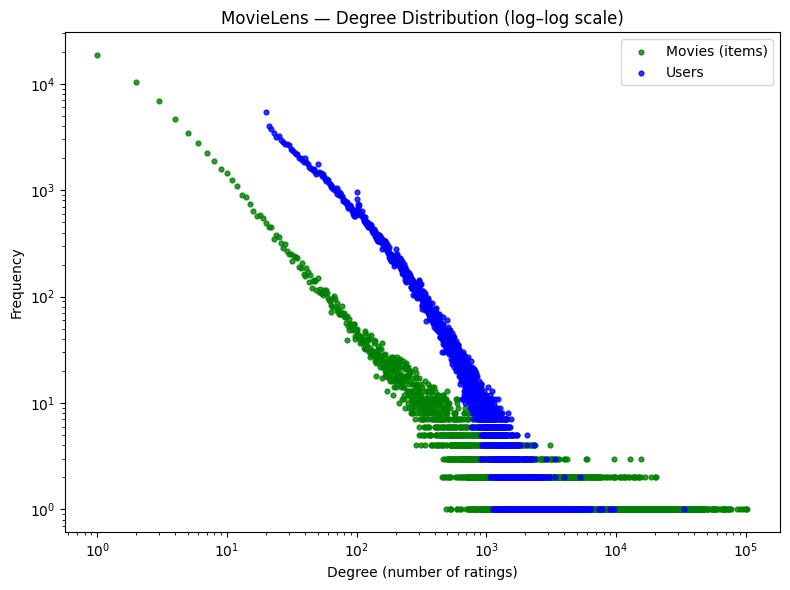

In [ ]:


# --------------------------------------------------------
# Compute degree counts from your FitData loader
# --------------------------------------------------------
movie_rating_counts = np.array([len(lst) for lst in data.data_by_movie], dtype=np.int32)
user_rating_counts  = np.array([len(lst) for lst in data.data_by_user], dtype=np.int32)

def degree_frequency(data):
    unique, counts = np.unique(data, return_counts=True)
    return unique, counts

movie_degree, movie_freq = degree_frequency(movie_rating_counts)
user_degree,  user_freq  = degree_frequency(user_rating_counts)

# --------------------------------------------------------
# Plot: Degree Distribution (log–log)
# --------------------------------------------------------
plt.figure(figsize=(8, 6))

plt.scatter(movie_degree, movie_freq, s=12, color='green',
            label='Movies (items)', alpha=0.8)
plt.scatter(user_degree, user_freq, s=12, color='blue',
            label='Users', alpha=0.8)

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Degree (number of ratings)')
plt.ylabel('Frequency')
plt.title('MovieLens — Degree Distribution (log–log scale)')
plt.legend()

plt.tight_layout()

# --------------------------------------------------------
# SAVE AS PDF
# --------------------------------------------------------
plt.savefig("degree_distribution.pdf", format="pdf")

plt.show()


## 100k Dataset

### 2.1: Load the dataset

In [ ]:
import os
import csv
import numpy as np
import pandas as pd
from utils import FitData
import matplotlib.pyplot as plt
import zipfile


In [ ]:


# Ensure data folder exists
os.makedirs("data", exist_ok=True)

# Download MovieLens small dataset
!wget -q https://files.grouplens.org/datasets/movielens/ml-latest-small.zip -O data/ml-latest-small.zip

# Unzip
with zipfile.ZipFile("data/ml-latest-small.zip", 'r') as zip_ref:
    zip_ref.extractall("data/")

# Check extracted folder
print("Contents of data folder:", os.listdir("data/"))

# Set correct data path
data_path = "data/ml-latest-small"
ratings_file = os.path.join(data_path, "ratings.csv")

# Make sure the file exists
if not os.path.exists(ratings_file):
    raise FileNotFoundError(f"{ratings_file} not found!")

# Load CSV into pandas
ratings = pd.read_csv(ratings_file)
print(ratings.head())
print("\nShape:", ratings.shape)


Contents of data folder: ['ml-latest-small', 'ml-32m', 'ml-latest-small.zip', 'ml-32m.zip']
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Shape: (100836, 4)


In [ ]:
file_path = os.path.join(data_path, data_file)

df = FitData(file_path)
df.load()


### 2.2: Split the dataset

In [ ]:
n_users = len(df.data_by_user)
n_movies = len(df.data_by_movie)

data_by_user_train = [[] for _ in range(n_users)]
data_by_user_test  = [[] for _ in range(n_users)]
data_by_movie_train = [[] for _ in range(n_movies)]
data_by_movie_test  = [[] for _ in range(n_movies)]

for i in range(n_users):
    ratings = df.data_by_user[i] # change variable name
    for movie_id, rating in ratings:
        if np.random.rand() < 0.9:
            data_by_user_train[i].append((movie_id, rating))
        else:
            data_by_user_test[i].append((movie_id, rating))

for i in range(n_users):
    user_id = df.idx_to_user_id[i]

    # train
    for movie_id, rating in data_by_user_train[i]:
        m_idx = df.movie_id_to_idx[movie_id]
        data_by_movie_train[m_idx].append((user_id, rating))

    # test
    for movie_id, rating in data_by_user_test[i]:
        m_idx = df.movie_id_to_idx[movie_id]
        data_by_movie_test[m_idx].append((user_id, rating))

In [ ]:
non_empty_users_train = sum(1 for u in data_by_user_train if len(u) > 0)
non_empty_users_test = sum(1 for u in data_by_user_test if len(u) > 0)

print(f"number of items in users train and test sets: {len(data_by_user_train)} , {len(data_by_user_test)}")
print(f"Number of users with ratings in train and test sets: {non_empty_users_train}, {non_empty_users_test}")

print()

non_empty_movies_train = sum(1 for u in data_by_movie_train if len(u) > 0)
non_empty_movies_test = sum(1 for u in data_by_movie_test if len(u) > 0)

print(f"number of items in movies train and test sets: {len(data_by_movie_train)}, {len(data_by_movie_test)}")
print(f"Number of movies with ratings in train and test sets: {non_empty_movies_train}, {non_empty_movies_test}")

number of items in users train and test sets: 610 , 610
Number of users with ratings in train and test sets: 610, 597

number of items in movies train and test sets: 9724, 9724
Number of movies with ratings in train and test sets: 9357, 3676


## 2.3: Bias Optimisation

Iter 1: Train RMSE=0.8049, Test RMSE=0.8842
Iter 2: Train RMSE=0.7892, Test RMSE=0.8705
Iter 3: Train RMSE=0.7880, Test RMSE=0.8699
Iter 4: Train RMSE=0.7878, Test RMSE=0.8698
Iter 5: Train RMSE=0.7877, Test RMSE=0.8698
Iter 6: Train RMSE=0.7877, Test RMSE=0.8697
Iter 7: Train RMSE=0.7877, Test RMSE=0.8697
Iter 8: Train RMSE=0.7877, Test RMSE=0.8696
Iter 9: Train RMSE=0.7877, Test RMSE=0.8696
Iter 10: Train RMSE=0.7876, Test RMSE=0.8695


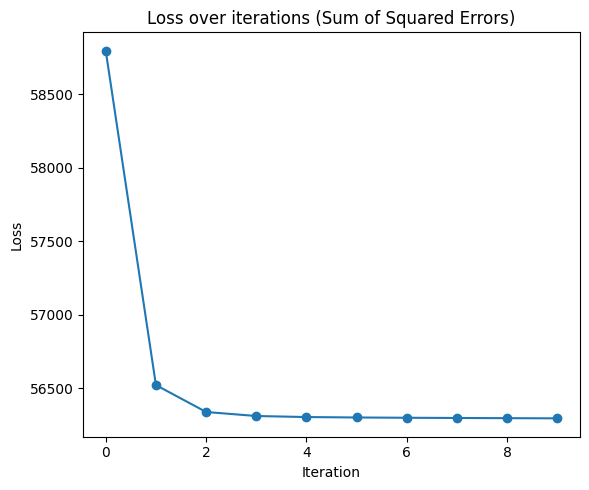

✓ Saved: 100k_loss_over_iterations.pdf


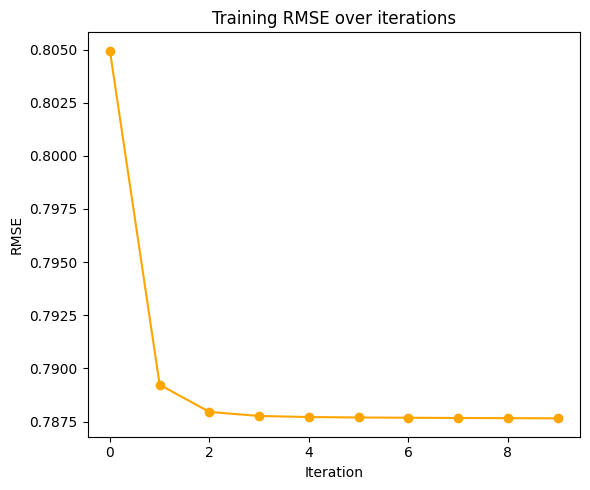

✓ Saved: 100k_train_rmse_over_iterations.pdf


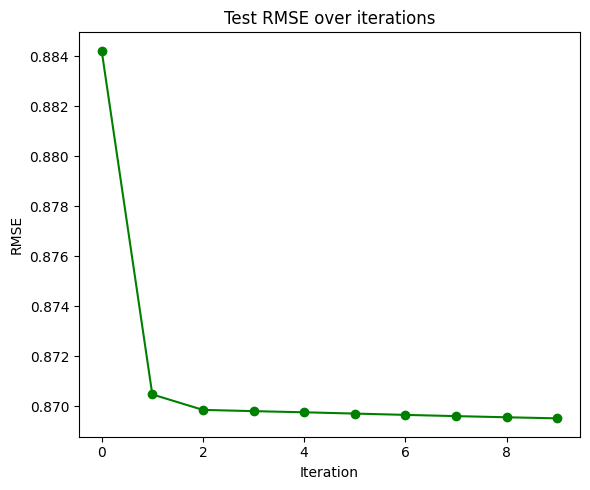

✓ Saved: 100k_test_rmse_over_iterations.pdf


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# Parameters
# ---------------------------
M = n_users    # number of users
N = n_movies   # number of movies

lambd = 0.6    # regularization weight
gamma = 1e-8   # small smoothing term
num_iters = 10

user_biases = np.zeros(M)
item_biases = np.zeros(N)

# Create figures folder if it doesn't exist
FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

# ---------------------------
# Compute global mean rating
# ---------------------------
mu = np.mean([r for user_ratings in data_by_user_train for (_, r) in user_ratings])

# ---------------------------
# Track metrics
# ---------------------------
loss_history = []
rmse_history = []
rmse_test_history = []

# ---------------------------
# ALS bias-only iterations
# ---------------------------
for it in range(num_iters):
    # --- Update user biases ---
    for m in range(M):
        num = 0.0
        cnt = 0
        for (movie_id, r) in data_by_user_train[m]:
            n = df.movie_id_to_idx[movie_id]
            num += (r - mu - item_biases[n])
            cnt += 1
        if cnt > 0:
            user_biases[m] = num / (lambd + cnt + gamma)

    # --- Update item biases ---
    for n in range(N):
        num = 0.0
        cnt = 0
        for (user_id, r) in data_by_movie_train[n]:
            m_idx = df.user_id_to_idx[user_id]
            num += (r - mu - user_biases[m_idx])
            cnt += 1
        if cnt > 0:
            item_biases[n] = num / (lambd + cnt + gamma)

    # --- Compute training RMSE ---
    sq_err = 0.0
    count = 0
    for m in range(M):
        for movie_id, r in data_by_user_train[m]:
            n = df.movie_id_to_idx[movie_id]
            pred = mu + user_biases[m] + item_biases[n]
            sq_err += (r - pred) ** 2
            count += 1
    rmse_train = np.sqrt(sq_err / count)
    rmse_history.append(rmse_train)
    loss_history.append(sq_err)

    # --- Compute test RMSE ---
    sq_err_test = 0.0
    count_test = 0
    for m in range(M):
        for movie_id, r in data_by_user_test[m]:
            n = df.movie_id_to_idx[movie_id]
            pred = mu + user_biases[m] + item_biases[n]
            sq_err_test += (r - pred) ** 2
            count_test += 1
    rmse_test = np.sqrt(sq_err_test / count_test)
    rmse_test_history.append(rmse_test)

    print(f"Iter {it+1}: Train RMSE={rmse_train:.4f}, Test RMSE={rmse_test:.4f}")

# ---------------------------
# Plot and save Loss
# ---------------------------
plt.figure(figsize=(6,5))
plt.plot(loss_history, marker='o')
plt.title("Loss over iterations (Sum of Squared Errors)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "100k_loss_over_iterations.pdf"), format='pdf', bbox_inches='tight')
plt.show()  # display in kernel
plt.close()
print(f"✓ Saved: 100k_loss_over_iterations.pdf")

# ---------------------------
# Plot and save Training RMSE
# ---------------------------
plt.figure(figsize=(6,5))
plt.plot(rmse_history, marker='o', color='orange')
plt.title("Training RMSE over iterations")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "100k_train_rmse_over_iterations.pdf"), format='pdf', bbox_inches='tight')
plt.show()  # display in kernel
plt.close()
print(f"✓ Saved: 100k_train_rmse_over_iterations.pdf")

# ---------------------------
# Plot and save Test RMSE
# ---------------------------
plt.figure(figsize=(6,5))
plt.plot(rmse_test_history, marker='o', color='green')
plt.title("Test RMSE over iterations")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "100k_test_rmse_over_iterations.pdf"), format='pdf', bbox_inches='tight')
plt.show()  # display in kernel
plt.close()
print(f"✓ Saved: 100k_test_rmse_over_iterations.pdf")


## 100k Dataset with user and Item vector update

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from utils import FitData
import os
import math

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

class ALS:
    def __init__(self, df, data_by_user_train, data_by_user_test,
                 data_by_movie_train, data_by_movie_test,
                 K=25, lambd=0.01, num_iters=10, fig_dir="figures"):
        
        self.df = df
        self.data_by_user_train = data_by_user_train
        self.data_by_user_test = data_by_user_test
        self.data_by_movie_train = data_by_movie_train
        self.data_by_movie_test = data_by_movie_test

        self.M = len(df.data_by_user)
        self.N = len(df.data_by_movie)
        self.K = K
        self.lambd = lambd
        self.num_iters = num_iters

        # Initialize parameters
        self.user_biases = np.zeros(self.M)
        self.item_biases = np.zeros(self.N)
        self.U = 0.1 * np.random.randn(self.M, K)
        self.V = 0.1 * np.random.randn(self.N, K)
        self.mu = np.mean([r for ratings in self.data_by_user_train for (_, r) in ratings])

        # Tracking history
        self.loss_hist = []
        self.rmse_hist = []
        self.rmse_test_hist = []

        # Create figures folder
        self.fig_dir = fig_dir
        os.makedirs(self.fig_dir, exist_ok=True)

    def train(self):
        for it in range(self.num_iters):
            self.update_user_biases()
            self.update_item_biases()
            self.update_user_latent()
            self.update_item_latent()
            self.compute_metrics(it)

    # ---------------------------
    # Bias updates
    # ---------------------------
    def update_user_biases(self):
        for m in range(self.M):
            num = 0.0
            den = self.lambd
            for (movie_id, r) in self.data_by_user_train[m]:
                n = self.df.movie_id_to_idx[movie_id]
                num += (r - self.mu - self.item_biases[n] - self.U[m] @ self.V[n])
                den += 1
            self.user_biases[m] = num / den

    def update_item_biases(self):
        for n in range(self.N):
            num = 0.0
            den = self.lambd
            for (user_id, r) in self.data_by_movie_train[n]:
                m = self.df.user_id_to_idx[user_id]
                num += (r - self.mu - self.user_biases[m] - self.U[m] @ self.V[n])
                den += 1
            self.item_biases[n] = num / den

    # ---------------------------
    # Latent factor updates
    # ---------------------------
    def update_user_latent(self):
        for m in range(self.M):
            A = self.lambd * np.eye(self.K)
            b = np.zeros(self.K)
            for (movie_id, r) in self.data_by_user_train[m]:
                n = self.df.movie_id_to_idx[movie_id]
                v = self.V[n]
                A += np.outer(v, v)
                b += v * (r - self.mu - self.user_biases[m] - self.item_biases[n])
            self.U[m] = np.linalg.solve(A, b)

    def update_item_latent(self):
        for n in range(self.N):
            A = self.lambd * np.eye(self.K)
            b = np.zeros(self.K)
            for (user_id, r) in self.data_by_movie_train[n]:
                m = self.df.user_id_to_idx[user_id]
                u = self.U[m]
                A += np.outer(u, u)
                b += u * (r - self.mu - self.user_biases[m] - self.item_biases[n])
            self.V[n] = np.linalg.solve(A, b)

    # ---------------------------
    # Compute regularized NLL (loss) and RMSE
    # ---------------------------
    def compute_metrics(self, iteration):
        # Regularized negative log likelihood
        loss = 0.0
        for m in range(self.M):
            for (movie_id, r) in self.data_by_user_train[m]:
                n = self.df.movie_id_to_idx[movie_id]
                pred = self.mu + self.user_biases[m] + self.item_biases[n] + self.U[m] @ self.V[n]
                loss += (r - pred) ** 2
        # Add regularization
        loss += self.lambd * (np.sum(self.user_biases**2) + np.sum(self.item_biases**2) +
                              np.sum(self.U**2) + np.sum(self.V**2))
        self.loss_hist.append(loss)

        # Training RMSE
        sq_err = 0.0
        count = 0
        for m in range(self.M):
            for (movie_id, r) in self.data_by_user_train[m]:
                n = self.df.movie_id_to_idx[movie_id]
                pred = self.mu + self.user_biases[m] + self.item_biases[n] + self.U[m] @ self.V[n]
                sq_err += (r - pred)**2
                count += 1
        rmse_train = np.sqrt(sq_err / count)
        self.rmse_hist.append(rmse_train)

        # Test RMSE
        sq_err_test = 0.0
        count_test = 0
        for m in range(self.M):
            for (movie_id, r) in self.data_by_user_test[m]:
                n = self.df.movie_id_to_idx[movie_id]
                pred = self.mu + self.user_biases[m] + self.item_biases[n] + self.U[m] @ self.V[n]
                sq_err_test += (r - pred)**2
                count_test += 1
        rmse_test = np.sqrt(sq_err_test / count_test)
        self.rmse_test_hist.append(rmse_test)

        print(f"Iter {iteration+1}: Loss={loss:.2f}, Train RMSE={rmse_train:.4f}, Test RMSE={rmse_test:.4f}")

    # ---------------------------
    # Plot metrics and save PDFs
    # ---------------------------
    def plot_metrics(self):
        # Loss
        plt.figure(figsize=(6,5))
        plt.plot(self.loss_hist, marker='o')
        plt.title("Regularized Negative Log Likelihood")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.tight_layout()
        plt.savefig(os.path.join(self.fig_dir, "loss_over_iterations.pdf"))
        plt.show()

        # Train RMSE
        plt.figure(figsize=(6,5))
        plt.plot(self.rmse_hist, marker='o', color='orange')
        plt.title("Training RMSE")
        plt.xlabel("Iteration")
        plt.ylabel("RMSE")
        plt.tight_layout()
        plt.savefig(os.path.join(self.fig_dir, "train_rmse_over_iterations.pdf"))
        plt.show()

        # Test RMSE
        plt.figure(figsize=(6,5))
        plt.plot(self.rmse_test_hist, marker='o', color='green')
        plt.title("Test RMSE")
        plt.xlabel("Iteration")
        plt.ylabel("RMSE")
        plt.tight_layout()
        plt.savefig(os.path.join(self.fig_dir, "test_rmse_over_iterations.pdf"))
        plt.show()


Iter 1: Loss=17093.93, Train RMSE=0.4249, Test RMSE=2.0486
Iter 2: Loss=13573.20, Train RMSE=0.3785, Test RMSE=1.9016
Iter 3: Loss=11836.40, Train RMSE=0.3529, Test RMSE=1.8604
Iter 4: Loss=10723.63, Train RMSE=0.3354, Test RMSE=1.8409
Iter 5: Loss=9938.44, Train RMSE=0.3224, Test RMSE=1.8230
Iter 6: Loss=9349.57, Train RMSE=0.3124, Test RMSE=1.8171
Iter 7: Loss=8885.13, Train RMSE=0.3042, Test RMSE=1.8127


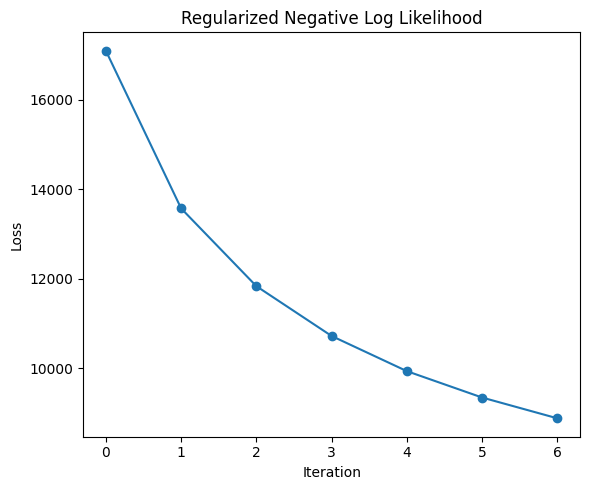

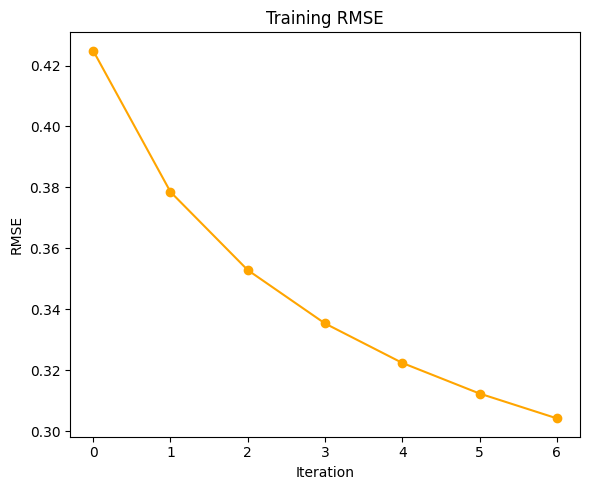

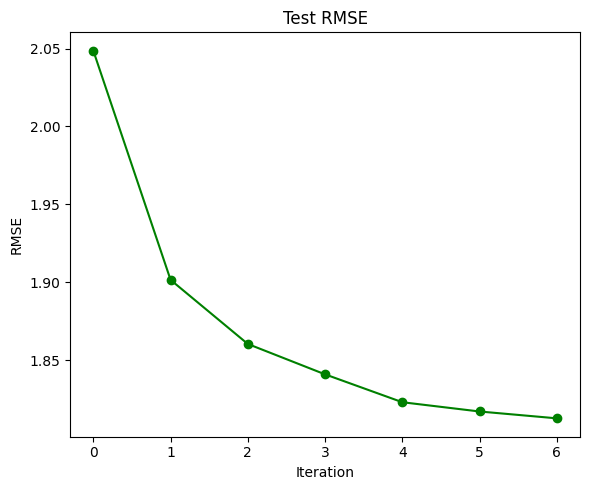

In [ ]:
# Initialize ALS
als_model = ALS(df, data_by_user_train, data_by_user_test,
                data_by_movie_train, data_by_movie_test,
                K=25, lambd=0.01, num_iters=7)

# Train the model
als_model.train()

# Plot metrics
als_model.plot_metrics()


## 32m Dataset training  (practical 3 and practical 4)

In [ ]:
import os
from utils import FitData

DATA_DIR = "data/ml-32m/ml-32m"  # note the extra ml-32m folder created by unzip
RATINGS_CSV = os.path.join(DATA_DIR, "ratings.csv")
MOVIES_CSV = os.path.join(DATA_DIR, "movies.csv")

print("Ratings CSV exists:", os.path.exists(RATINGS_CSV))
print("Movies CSV exists:", os.path.exists(MOVIES_CSV))

df = FitData(RATINGS_CSV, MOVIES_CSV)
df.load()



Ratings CSV exists: True
Movies CSV exists: True


In [ ]:
import os
import math
import pickle
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange

FIG_DIR = "figures"
MODEL_DIR = "models"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)


# ----------------------------
# Numba-compiled helpers
# ----------------------------

@njit(parallel=True)
def _update_user_biases_numba(M, mu, lambd, U, V, item_biases,
                              user_items_flat, user_items_ptr, user_items_len,
                              user_ratings_flat):
    for m in prange(M):
        start = user_items_ptr[m]
        ln = user_items_len[m]
        num = 0.0
        den = lambd
        Um = U[m]
        for k in range(ln):
            idx = start + k
            n = user_items_flat[idx]
            r = user_ratings_flat[idx]
            # dot product U[m] @ V[n]
            dot = 0.0
            Vn = V[n]
            for t in range(Vn.shape[0]):
                dot += Um[t] * Vn[t]
            num += r - mu - item_biases[n] - dot
            den += 1.0
        user_bias = 0.0
        if den > 0.0:
            user_bias = num / den
        # write back
        for t in range(1):  # dummy block to avoid numba warning about scalars
            user_biases[m] = user_bias


@njit(parallel=True)
def _update_item_biases_numba(N, mu, lambd, U, V, user_biases,
                              movie_users_flat, movie_users_ptr, movie_users_len,
                              movie_ratings_flat):
    for n in prange(N):
        start = movie_users_ptr[n]
        ln = movie_users_len[n]
        num = 0.0
        den = lambd
        Vn = V[n]
        for k in range(ln):
            idx = start + k
            m = movie_users_flat[idx]
            r = movie_ratings_flat[idx]
            # dot U[m] @ V[n]
            dot = 0.0
            Um = U[m]
            for t in range(Um.shape[0]):
                dot += Um[t] * Vn[t]
            num += r - mu - user_biases[m] - dot
            den += 1.0
        item_bias = 0.0
        if den > 0.0:
            item_bias = num / den
        item_biases[n] = item_bias


@njit(parallel=True)
def _update_user_latent_numba(M, K, mu, lambd, U, V, user_biases,
                              user_items_flat, user_items_ptr, user_items_len,
                              user_ratings_flat):
    # For each user, build A (KxK) and b (K) then solve A x = b
    for m in prange(M):
        start = user_items_ptr[m]
        ln = user_items_len[m]
        # allocate A and b
        A = np.zeros((K, K))
        b = np.zeros(K)
        # regularization on diagonal
        for d in range(K):
            A[d, d] = lambd
        ub = user_biases[m]
        Um = U[m]  # used only for shape, not for computing A
        for k in range(ln):
            idx = start + k
            n = user_items_flat[idx]
            r = user_ratings_flat[idx]
            Vn = V[n]
            # A += outer(Vn, Vn)
            for i in range(K):
                vi = Vn[i]
                for j in range(K):
                    A[i, j] += vi * Vn[j]
                b[i] += Vn[i] * (r - mu - ub - 0.0 - 0.0)  # item_bias term omitted here; we add it below
            # we need item bias; but we cannot access it here (we did not pass item_biases).
            # The caller should have removed item_bias from r before building user_ratings_flat OR
            # we will store raw ratings only and pass item_biases separately. To keep signature
            # small, this function expects user_ratings_flat to already be (r - item_bias[n])
            # We'll clarify in class: we will supply residual ratings adjusted by item_bias.
        # Solve A x = b (numba supports np.linalg.solve)
        x = np.linalg.solve(A, b)
        for d in range(K):
            U[m, d] = x[d]


@njit(parallel=True)
def _update_item_latent_numba(N, K, mu, lambd, U, V, item_biases,
                              movie_users_flat, movie_users_ptr, movie_users_len,
                              movie_ratings_flat):
    for n in prange(N):
        start = movie_users_ptr[n]
        ln = movie_users_len[n]
        A = np.zeros((K, K))
        b = np.zeros(K)
        for d in range(K):
            A[d, d] = lambd
        ib = item_biases[n]
        for k in range(ln):
            idx = start + k
            m = movie_users_flat[idx]
            r = movie_ratings_flat[idx]
            Um = U[m]
            for i in range(K):
                ui = Um[i]
                for j in range(K):
                    A[i, j] += ui * Um[j]
                b[i] += Um[i] * (r - mu - 0.0 - ib)  # user_bias term omitted; movie_ratings_flat should be adjusted
        x = np.linalg.solve(A, b)
        for d in range(K):
            V[n, d] = x[d]


# ----------------------------
# ALS class (Numba-Ready)
# ----------------------------
class ALSRecommenderNumba:
    def __init__(self, ratings_df, K=20, lambd=0.05, num_iters=10, test_ratio=0.2, dtype=np.float64):
        self.df = ratings_df
        self.K = K
        self.lambd = float(lambd)
        self.num_iters = int(num_iters)
        self.test_ratio = float(test_ratio)
        self.dtype = dtype

        self.M = self.df.num_users()
        self.N = self.df.num_movies()

        # Train/test containers (Python lists initially)
        self.data_by_user_train = []
        self.data_by_user_test = []
        self.data_by_movie_train = [[] for _ in range(self.N)]
        self.data_by_movie_test  = [[] for _ in range(self.N)]

        # ALS parameters (NumPy arrays)
        self.U = np.random.randn(self.M, K).astype(self.dtype) * 0.1
        self.V = np.random.randn(self.N, K).astype(self.dtype) * 0.1
        self.user_biases = np.zeros(self.M, dtype=self.dtype)
        self.item_biases = np.zeros(self.N, dtype=self.dtype)
        self.mu = 0.0

        # Flattened arrays for Numba (populated after train_test_split)
        self.user_items_flat = None       # int32
        self.user_items_ptr = None        # int32, start index per user
        self.user_items_len = None        # int32, length per user
        self.user_ratings_flat = None     # float

        self.movie_users_flat = None      # int32
        self.movie_users_ptr = None       # int32
        self.movie_users_len = None       # int32
        self.movie_ratings_flat = None    # float

        # History
        self.loss_hist = []
        self.rmse_hist = []
        self.rmse_test_hist = []

        print(f"[LOG INIT] Numba ALS initialized: M={self.M}, N={self.N}, K={K}, lambda={lambd}, num_iters={num_iters}")

    # ----------------------
    # Train/test split + flattening
    # ----------------------
    def train_test_split(self):
        print("[LOG] Performing train/test split...")
        self.data_by_user_train = []
        self.data_by_user_test = []
        self.data_by_movie_train = [[] for _ in range(self.N)]
        self.data_by_movie_test  = [[] for _ in range(self.N)]

        for u_idx, ratings in enumerate(self.df.data_by_user):
            n_ratings = len(ratings)
            if n_ratings == 0:
                self.data_by_user_train.append([])
                self.data_by_user_test.append([])
                continue
            split_idx = int(math.ceil((1 - self.test_ratio) * n_ratings))
            train_ratings = ratings[:split_idx]
            test_ratings = ratings[split_idx:]

            self.data_by_user_train.append(train_ratings)
            self.data_by_user_test.append(test_ratings)

            for movie_id, r in train_ratings:
                m_idx = self.df.movie_id_to_idx[movie_id]
                self.data_by_movie_train[m_idx].append((self.df.idx_to_user_id[u_idx], r))
            for movie_id, r in test_ratings:
                m_idx = self.df.movie_id_to_idx[movie_id]
                self.data_by_movie_test[m_idx].append((self.df.idx_to_user_id[u_idx], r))

        all_train_ratings = [r for ratings in self.data_by_user_train for (_, r) in ratings]
        self.mu = float(np.mean(all_train_ratings)) if all_train_ratings else 0.0
        print(f"[LOG] Train/test split done. Global mean rating: {self.mu:.4f}")

        # --------------------------
        # Build flattened arrays for Numba
        # --------------------------
        # User side flattening
        user_offsets = np.zeros(self.M + 1, dtype=np.int32)
        total_user_entries = sum(len(ratings) for ratings in self.data_by_user_train)
        user_items_flat = np.empty(total_user_entries, dtype=np.int32)
        user_ratings_flat = np.empty(total_user_entries, dtype=self.dtype)

        pos = 0
        for m in range(self.M):
            ratings = self.data_by_user_train[m]
            user_offsets[m] = pos
            for (movie_id, r) in ratings:
                idx_movie = self.df.movie_id_to_idx[movie_id]
                user_items_flat[pos] = idx_movie
                user_ratings_flat[pos] = r
                pos += 1
        user_offsets[self.M] = pos
        user_ptr = user_offsets[:-1].astype(np.int32)
        user_len = (user_offsets[1:] - user_offsets[:-1]).astype(np.int32)

        # Movie side flattening
        movie_offsets = np.zeros(self.N + 1, dtype=np.int32)
        total_movie_entries = sum(len(ratings) for ratings in self.data_by_movie_train)
        movie_users_flat = np.empty(total_movie_entries, dtype=np.int32)
        movie_ratings_flat = np.empty(total_movie_entries, dtype=self.dtype)

        pos = 0
        for n in range(self.N):
            ratings = self.data_by_movie_train[n]
            movie_offsets[n] = pos
            for (user_id, r) in ratings:
                idx_user = self.df.user_id_to_idx[user_id]
                movie_users_flat[pos] = idx_user
                movie_ratings_flat[pos] = r
                pos += 1
        movie_offsets[self.N] = pos
        movie_ptr = movie_offsets[:-1].astype(np.int32)
        movie_len = (movie_offsets[1:] - movie_offsets[:-1]).astype(np.int32)

        # store flattened arrays
        self.user_items_flat = user_items_flat.astype(np.int32)
        self.user_items_ptr = user_ptr
        self.user_items_len = user_len
        self.user_ratings_flat = user_ratings_flat.astype(self.dtype)

        self.movie_users_flat = movie_users_flat.astype(np.int32)
        self.movie_users_ptr = movie_ptr
        self.movie_users_len = movie_len
        self.movie_ratings_flat = movie_ratings_flat.astype(self.dtype)

    # ----------------------
    # Fit (ALS)
    # ----------------------
    def fit(self):
        if self.user_items_flat is None:
            raise RuntimeError("Call train_test_split() before fit().")
        print("[LOG] Starting Numba-optimized ALS training...")
        for it in range(self.num_iters):
            print(f"[LOG] Iter {it+1}/{self.num_iters}")
            # 1) Update user biases (parallel)
            _update_user_biases_numba(
                self.M, self.mu, self.lambd,
                self.U, self.V, self.item_biases,
                self.user_items_flat, self.user_items_ptr, self.user_items_len,
                self.user_ratings_flat
            )

            # 2) Update item biases (parallel)
            _update_item_biases_numba(
                self.N, self.mu, self.lambd,
                self.U, self.V, self.user_biases,
                self.movie_users_flat, self.movie_users_ptr, self.movie_users_len,
                self.movie_ratings_flat
            )

            # 3) Update user latent vectors (parallel)
            _update_user_latent_numba(
                self.M, self.K, self.mu, self.lambd,
                self.U, self.V, self.user_biases,
                self.user_items_flat, self.user_items_ptr, self.user_items_len,
                self.user_ratings_flat
            )

            # 4) Update item latent vectors (parallel)
            _update_item_latent_numba(
                self.N, self.K, self.mu, self.lambd,
                self.U, self.V, self.item_biases,
                self.movie_users_flat, self.movie_users_ptr, self.movie_users_len,
                self.movie_ratings_flat
            )

            # metrics (computed on Python side; can be heavy but OK once per iter)
            rmse_train, rmse_test, loss = self.compute_metrics()
            self.rmse_hist.append(rmse_train)
            self.rmse_test_hist.append(rmse_test)
            self.loss_hist.append(loss)
            print(f"[LOG ITER {it+1}] Loss={loss:.4f}, Train RMSE={rmse_train:.4f}, Test RMSE={rmse_test:.4f}")
        print("[LOG] Training done.")

    # ----------------------
    # Compute metrics (python side)
    # ----------------------
    def compute_metrics(self):
        sq_err, cnt = 0.0, 0
        for m in range(self.M):
            start = self.user_items_ptr[m]
            ln = self.user_items_len[m]
            for k in range(ln):
                idx = start + k
                n = int(self.user_items_flat[idx])
                r = float(self.user_ratings_flat[idx])
                pred = self.mu + float(self.user_biases[m]) + float(self.item_biases[n]) + float(self.U[m] @ self.V[n])
                sq_err += (r - pred) ** 2
                cnt += 1
        rmse_train = math.sqrt(sq_err / cnt) if cnt else float('nan')

        sq_err_test, cnt_test = 0.0, 0
        for m in range(self.M):
            for movie_id, r in self.data_by_user_test[m]:
                n = self.df.movie_id_to_idx[movie_id]
                pred = self.mu + float(self.user_biases[m]) + float(self.item_biases[n]) + float(self.U[m] @ self.V[n])
                sq_err_test += (r - pred) ** 2
                cnt_test += 1
        rmse_test = math.sqrt(sq_err_test / cnt_test) if cnt_test else float('nan')

        reg_loss = self.lambd * (np.sum(self.U**2) + np.sum(self.V**2))
        total_loss = sq_err + reg_loss
        return rmse_train, rmse_test, float(total_loss)

    # ----------------------
    # Save / load
    # ----------------------
    def save_model(self, filename):
        filepath = os.path.join(MODEL_DIR, filename)
        with open(filepath, 'wb') as f:
            pickle.dump(self, f)
        print(f"[LOG] Model saved to {filepath}")

    # ----------------------
    # Plotting
    # ----------------------
    def plot_metrics(self):
        iterations = range(1, len(self.loss_hist) + 1)
        plt.figure(figsize=(8, 5))
        plt.plot(iterations, self.loss_hist, marker='o', label="Loss")
        plt.xlabel("Iteration"); plt.ylabel("Loss"); plt.grid(True); plt.legend(); plt.show()

        plt.figure(figsize=(8, 5))
        plt.plot(iterations, self.rmse_hist, marker='o', label="Train RMSE")
        plt.plot(iterations, self.rmse_test_hist, marker='x', label="Test RMSE")
        plt.xlabel("Iteration"); plt.ylabel("RMSE"); plt.grid(True); plt.legend(); plt.show()


# ----------------------------
# Utility: train multiple K (same API)
# ----------------------------
def train_multiple_K_numba(df, K_list=[10, 20], lambd=0.05, num_iters=10):
    trained_models = {}
    for K in K_list:
        print(f"\n[LOG] Training ALS (Numba) with K={K}")
        als = ALSRecommenderNumba(df, K=K, lambd=lambd, num_iters=num_iters)
        als.train_test_split()
        als.fit()
        als.save_model(f"als_numba_K{K}.pkl")
        trained_models[K] = als
    return trained_models


In [ ]:
# Train multiple K
trained_models = train_multiple_K(df, K_list=[5, 10, 20], lambd=0.05, num_iters=5)
plot_comparative_metrics(trained_models, num_iters=10)

# Load a specific model later
selected_K = int(input("Enter K to load ALS model (5,10,20): "))
model = load_model(selected_K)
if model:
    model.plot_metrics()



[LOG] Training ALS with K=5
[LOG INIT] ALS initialized: M=200948, N=84432, K=5, lambda=0.05, num_iters=5
[LOG] Performing train/test split...
[LOG] Train/test split done. Global mean rating: 3.5442
[LOG] Starting ALS training...
[LOG] Iteration 1/5
[LOG ITER 1] Loss=17958457.71, Train RMSE=0.8345, Test RMSE=0.9591
[LOG] Iteration 2/5


KeyboardInterrupt: 

In [ ]:
# -----------------------
# Initialize ALS Recommender
# -----------------------
print("[INFO] Initializing ALS Recommender...")
als = ALSRecommender(df, K=20, lambd=0.05, num_iters=10)
print(f"[INFO] ALS Recommender initialized with K={als.K}, lambda={als.lambd}, num_iters={als.num_iters}")

# -----------------------
# Train/test split
# -----------------------
als.train_test_split()
print("[INFO] Train/test split completed")

total_train_ratings = sum(len(r) for r in als.data_by_user_train)
total_test_ratings = sum(len(r) for r in als.data_by_user_test)
print(f"[INFO] Total train ratings: {total_train_ratings}, Total test ratings: {total_test_ratings}")


# -----------------------
# Fit model
# -----------------------
print("[INFO] Starting ALS training...")
als.fit()
print("[INFO] ALS training completed")


# -----------------------
# Plot RMSE curves
# -----------------------
print("[INFO] Plotting RMSE curves...")
als.plot_rmse()
print("[INFO] RMSE curves plotted")




[INFO] Initializing ALS Recommender...
[INIT] ALS Recommender initialized with 200948 users, 84432 movies, K=20, lambda=0.05
[INFO] ALS Recommender initialized with K=20, lambda=0.05, num_iters=10
[INFO] Performing train/test split...
[INFO] Train/test split completed. Global mean rating: 3.5442
[INFO] Train/test split completed
[INFO] Total train ratings: 25677530, Total test ratings: 6322674
[INFO] Starting ALS training...
[INFO] Starting ALS training...
[ITER] Starting iteration 1/10
[INFO] User biases updated.
[INFO] Item biases updated.
[INFO] User latent factors updated.
[INFO] Item latent factors updated.
[INFO] RMSE computed. Train: 0.7711, Test: 1.0703
[ITER 1] Train RMSE=0.7711, Test RMSE=1.0703
[ITER] Starting iteration 2/10
[INFO] User biases updated.
[INFO] Item biases updated.
[INFO] User latent factors updated.
[INFO] Item latent factors updated.
[INFO] RMSE computed. Train: 0.7197, Test: 1.0473
[ITER 2] Train RMSE=0.7197, Test RMSE=1.0473
[ITER] Starting iteration 3/10


In [ ]:
# -----------------------
# Helper: Convert movie IDs → titles
# -----------------------
def movie_titles(movie_ids, df):
    result = []
    for mid in movie_ids:
        title = df.movie_id_to_title.get(mid, str(mid))
        result.append(title)
    return result

print("[INFO] Creating dummy user and rating movies...")

# Create new user ID
dummy_user_id = df.num_users() + 1

# -----------------------
# Dummy user rating a LOTR movie
# -----------------------
dummy_ratings = [
    (4993, 5.0),   # Lord of the Rings: The Fellowship of the Ring
]

# Add user latent vector + bias
als.U = np.vstack([als.U, np.random.randn(1, als.K) * 0.1])
als.user_biases = np.append(als.user_biases, 0)

# Register user in dataset
df.user_id_to_idx[dummy_user_id] = len(df.idx_to_user_id)
df.idx_to_user_id.append(dummy_user_id)
df.data_by_user.append(dummy_ratings)

# Add rating into movie → user list
for movie_id, rating in dummy_ratings:
    df.data_by_movie[df.movie_id_to_idx[movie_id]].append((dummy_user_id, rating))

# -----------------------
# Show what user rated
# -----------------------
rated_movie_ids = [mid for mid, _ in dummy_ratings]
rated_titles = movie_titles(rated_movie_ids, df)

print("[INFO] Dummy user rated the following movies:")
for title, (_, rating) in zip(rated_titles, dummy_ratings):
    print(f"- {title} with {rating} stars")

# -----------------------
# Generate recommendations
# -----------------------
top_movies = als.recommend_for_user(dummy_user_id, top_n=10)
print("[INFO] Top recommendations for dummy user:")

top_titles = movie_titles(top_movies, df)
for title in top_titles:
    print(f"- {title}")

# -----------------------
# Polarizing movies (unchanged)
# -----------------------
print("[INFO] Finding top polarizing movies...")
polarizing = als.polarizing_movies(top_n=10)

print("[INFO] Top polarizing movies (title, norm):")
for mid, norm in polarizing:
    title = df.movie_id_to_title.get(mid, str(mid))
    print(f"- {title}: {norm:.4f}")


[INFO] Creating dummy user and rating movies...
[INFO] Dummy user rated the following movies:
- Lord of the Rings: The Fellowship of the Ring, The (2001) with 5.0 stars
[INFO] Generating recommendations for user 162543...
[INFO] Returning top 10 recommendations for user 162543.
[INFO] Top recommendations for dummy user:
- 12 Chairs (1976)
- Gidget (1959)
- Copenhagen (2014)
- Maggie (2015)
- 20,000 Days on Earth (2014)
- Survivor (2015)
- Unfaithfully Yours (1948)
- Halloweentown II: Kalabar's Revenge (2001)
- Dance of the Dead (2008)
- Bob & Carol & Ted & Alice (1969)
[INFO] Finding top polarizing movies...
[INFO] Found top 10 polarizing movies.
[INFO] Top polarizing movies (title, norm):
- Samurai Cop (1989): 7.6644
- Legend of Boggy Creek, The (1972): 7.3179
- 11-11-11 (11-11-11: The Prophecy) (2011): 7.3139
- DysFunktional Family (2003): 7.1664
- Outer Space (2000): 7.0212
- Outrageous Class (Hababam sinifi) (1975): 6.9089
- Slipstream (2007): 6.8322
- Scarlet Diva (2000): 6.7737
-